# Lab14-2 GAN_初始GAN範例(not homework)
110065508 李丞恩

In [1]:
SAMPLE_COL = 16
SAMPLE_ROW = 16
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 28
IMG_W = 28
IMG_C = 1
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 5000
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUF = 65536

DC_LR = 2.5e-04
DC_EPOCH = 256

W_LR = 2.0e-04
W_EPOCH = 256
WClipLo = -0.01
WClipHi = 0.01

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy

2021-12-18 01:36:51.640698: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warnings and info

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], \
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 10000)])

2021-12-18 01:36:53.261146: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-18 01:36:53.297058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 01:36:53.297564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.852GHz coreCount: 28 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 335.32GiB/s
2021-12-18 01:36:53.297583: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-18 01:36:53.307660: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-18 01:36:53.307696: I tensorflow/stream_executor/pl

## 一. 引入mnist dataset

In [5]:
# Load images, discard labels
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

iTrain = train_images.reshape(-1, 28, 28, 1).astype(np.float32)

# Normalizing the images to the range of [0., 1.]
iTrain = iTrain / 255.0

dsTrain = tf.data.Dataset.from_tensor_slices(iTrain).shuffle(BUF).batch(BATCH_SIZE, drop_remainder=True)

# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

2021-12-18 01:36:53.563487: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-18 01:36:53.563919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 01:36:53.564428: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.852GHz coreCount: 28 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 335.32GiB/s
2021-12-18 01:36:53.564493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative va

## 二. 設計GAN的架構

In [6]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])


In [7]:
DC_G, DC_D = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(DC_LR)
optimizer_d = keras.optimizers.Adam(DC_LR)

cross_entropy = keras.losses.BinaryCrossentropy(from_logits = True)

def DC_G_Loss(c0):
    """
    c0: logits of fake images
    """
    return cross_entropy(tf.ones_like(c0), c0)

def DC_D_Loss(c0, c1):
    """
    c0: logits of fake images
    c1: logits of real images
    """
    l1 = cross_entropy(tf.ones_like(c1), c1)
    l0 = cross_entropy(tf.zeros_like(c0), c0)
    return l1 + l0

## 三. GAN的訓練

In [8]:
@tf.function
def DC_D_Train(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tp:
        c0 = DC_G(z, training = True)

        z0 = DC_D(c0, training = True)
        z1 = DC_D(c1, training = True)

        lg = DC_G_Loss(z0)
        ld = DC_D_Loss(z0, z1)

    gradient_d = tp.gradient(ld, DC_D.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, DC_D.trainable_variables))
    
    return lg, ld

@tf.function
def DC_G_Train(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tp:
        c0 = DC_G(z, training = True)

       
        z1 = DC_D(c1, training = True)
        z0 = DC_D(c0, training = True)

        lg = DC_G_Loss(z0)
        ld = DC_D_Loss(z0, z1)

    gradient_g = tp.gradient(lg, DC_G.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, DC_G.trainable_variables))
    
    return lg, ld

In [9]:
DC_G, DC_D = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(DC_LR)
optimizer_d = keras.optimizers.Adam(DC_LR)

cross_entropy = keras.losses.BinaryCrossentropy(from_logits = True)

def DC_G_Loss(c0):
    """
    c0: logits of fake images
    """
    return cross_entropy(tf.ones_like(c0), c0)

def DC_D_Loss(c0, c1):
    """
    c0: logits of fake images
    c1: logits of real images
    """
    l1 = cross_entropy(tf.ones_like(c1), c1)
    l0 = cross_entropy(tf.zeros_like(c0), c0)
    return l1 + l0

@tf.function
def DC_D_Train(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tp:
        c0 = DC_G(z, training = True)

        z0 = DC_D(c0, training = True)
        z1 = DC_D(c1, training = True)

        lg = DC_G_Loss(z0)
        ld = DC_D_Loss(z0, z1)

    gradient_d = tp.gradient(ld, DC_D.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, DC_D.trainable_variables))
    
    return lg, ld

@tf.function
def DC_G_Train(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tp:
        c0 = DC_G(z, training = True)

       
        z1 = DC_D(c1, training = True)
        z0 = DC_D(c0, training = True)

        lg = DC_G_Loss(z0)
        ld = DC_D_Loss(z0, z1)

    gradient_g = tp.gradient(lg, DC_G.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, DC_G.trainable_variables))
    
    return lg, ld

In [10]:
# ratio of training step D:G = 5:1
DCTrain = (
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_G_Train
)

DCCritic = len(DCTrain)

## 四. 訓練過程視覺化

Generator Initial Output :


2021-12-18 01:36:54.427244: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-18 01:36:55.048549: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-12-18 01:36:55.048585: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-12-18 01:36:55.067166: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-12-18 01:36:55.637982: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2021-12-18 01:36:56.728728: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-18 01:36:56.728753: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2021-12-18 01:36:56.729199: E tensorf

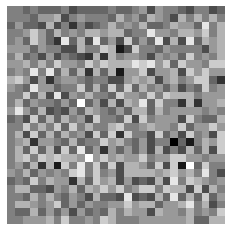

Discriminator Initial Output : 3.791069E-03


In [11]:
print("Generator Initial Output :")
c0 = DC_G(tf.random.normal((1, Z_DIM)), training = False)
plt.imshow((c0[0, :, :, 0] * 255.0).numpy().astype(np.uint8), cmap = "gray")
plt.axis("off")
plt.show()
print("Discriminator Initial Output : %E" % DC_D(c0).numpy())

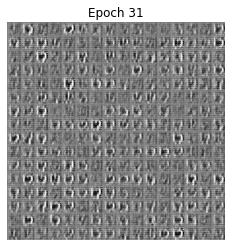

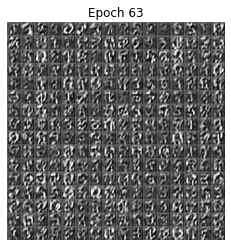

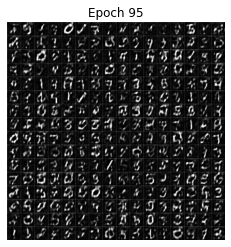

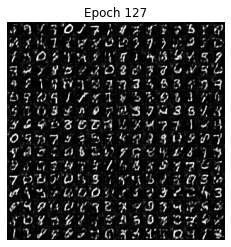

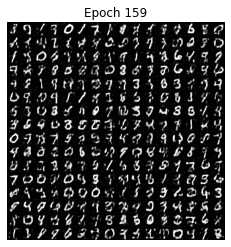

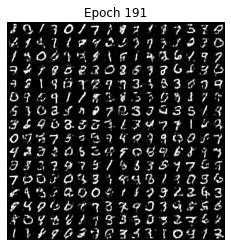

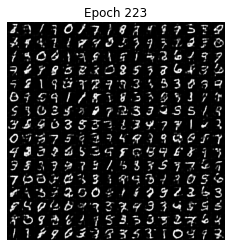

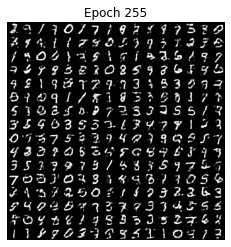

In [13]:
dc_lg = [None] * DC_EPOCH #record loss of g for each epoch
dc_ld = [None] * DC_EPOCH #record loss of d for each epoch
dc_sp = [None] * DC_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(len(iTrain))
ctr = 0
for ep in range(DC_EPOCH):
    loss_g_t = 0.0
    loss_d_t = 0.0
    for batch in dsTrain:
        loss_g, loss_d = DCTrain[ctr](batch)
        ctr += 1
        loss_g_t += loss_g.numpy()
        loss_d_t += loss_d.numpy()
        if ctr == DCCritic : ctr = 0
    dc_lg[ep] = loss_g_t * rsTrain
    dc_ld[ep] = loss_d_t * rsTrain
    
    out = DC_G(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "./output/imgs_not_HW/dc_%04d.png" % ep
    )
    dc_sp[ep] = img
    if (ep + 1) % 32 == 0:
        plt.imshow(img[..., 0], cmap = "gray")
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

In [14]:
utMakeGif(np.array(dc_sp), "./output/gif/dcgan.gif", duration = 2)

MoviePy - Building file imgs/dcgan.gif with imageio.


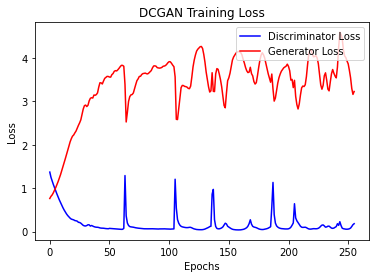

In [15]:
plt.plot(range(DC_EPOCH), dc_ld, color = "blue", label = "Discriminator Loss")
plt.plot(range(DC_EPOCH), dc_lg, color = "red",  label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("DCGAN Training Loss")
plt.show()